In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
#PATH = "./data/dogscats/"
PATH = "./data/ternonter/"
sz=224

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

In [7]:
os.listdir(PATH)

['tmp', 'models', 'train', 'test1', 'valid']

In [9]:
os.listdir(f'{PATH}valid')

['ter', 'nonter']

In [10]:
files = os.listdir(f'{PATH}valid/nonter')
#files = os.listdir(f'{PATH}valid/cats')
np.shape(files)

(11571,)

In [68]:
img = plt.imread(f'{PATH}valid/nonter/{files[1574]}')
#img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

In [89]:
# code is for removing 4th channel (which came because of using gdal_translate)

import cv2
import os

pathdir = '/home/rahul/code/fastai/courses/dl1/data/ternonter/valid/ter/'
flist = os.listdir(pathdir)
for fname in flist:
    if '.jpg' in fname:
        img = cv2.imread(pathdir+fname)
        cv2.imwrite(pathdir+'out_'+fname, img)


In [79]:
np.shape(img)

(256, 256, 3)

In [95]:
shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [8]:
arch=resnet34

In [9]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))

In [10]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [98]:

learn.fit(0.01, 3)#after lr find gave 10^-1

100%|██████████| 204/204 [00:58<00:00,  3.46it/s]


epoch      trn_loss   val_loss   accuracy                    
    0      0.302487   0.463901   0.792202  
    1      0.272233   0.642987   0.743828                    
    2      0.255073   0.412862   0.815427                    



[array([0.41286]), 0.8154272090964232]

In [99]:
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.25058    0.438813   0.810121  
    1      0.242546   0.552442   0.770053                    



[array([0.55244]), 0.7700530646682143]

In [132]:
log_preds = learn.predict()
log_preds.shape

(13003, 2)

In [133]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])  
np.max(probs)

0.99982214

In [134]:
data.classes

['nonter', 'ter']

In [103]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

In [104]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

def sort_by_prob_more(): 
    return most_by_mask_more( (data.val_y>-1))

def most_by_mask_more(mask):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(-1 * probs[idxs])[:120:2]]
    #return idxs[np.argsort(-1 * probs[idxs])[:1800:30]]

def plot_val_with_title_more(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=15, titles=title_probs, figsize=(16,80)) if len(imgs)>0 else print('Not Found.')

Most incorrect nonterrain


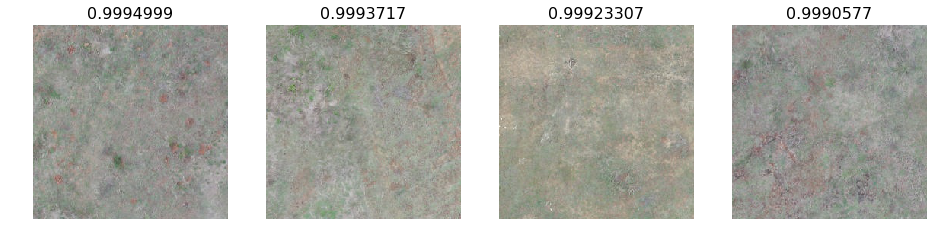

In [105]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect nonterrain")

In [106]:
plot_val_with_title(most_by_correct(1, True), "Most correct terrain")

Most correct terrain


Most correct 


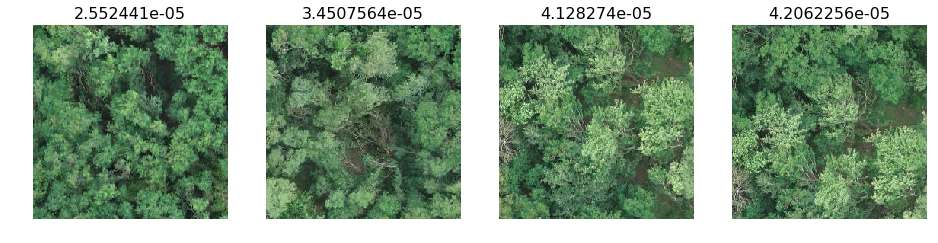

In [135]:
plot_val_with_title(most_by_correct(0, True), "Most correct ")

In [107]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf=learn.lr_find()

 78%|███████▊  | 206/263 [00:04<00:01, 45.05it/s, loss=0.875]


In [108]:
learn.sched.plot()

In [11]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_top_down, max_zoom=1.2)

In [111]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

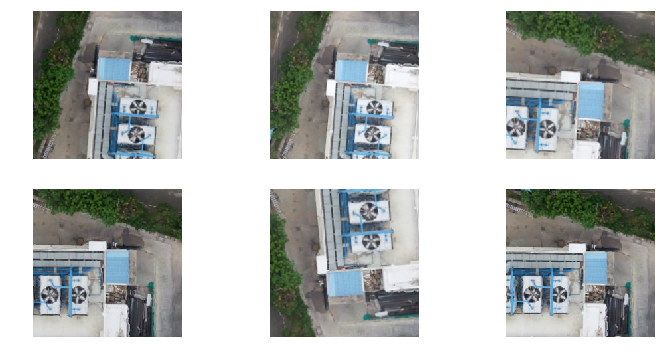

In [112]:
ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

In [12]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

In [40]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 38/38 [00:10<00:00,  4.35it/s]


In [115]:
learn.fit(2*1e-2, 5)

epoch      trn_loss   val_loss   accuracy                    
    0      0.32338    0.657533   0.739522  
    1      0.278474   0.50654    0.792817                    
    2      0.259296   0.648627   0.756518                    
    3      0.241497   0.624538   0.757825                    
    4      0.227189   0.564169   0.767208                    



[array([0.56417]), 0.7672075675027623]

In [116]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.206728   0.620178   0.758287  
    1      0.204124   0.591508   0.77136                     
    2      0.189228   0.618274   0.764824                    



[array([0.61827]), 0.7648235022595394]

In [117]:
learn.save('224_lastlayer_terrain_train_aug')

learn.load('224_lastlayer_terrain_train_aug')

In [13]:
learn.unfreeze()

In [42]:
lr=np.array([0.2*1e-2,0.6*1e-2,2*1e-2])

In [120]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.264661   0.414934   0.818965  
    1      0.253636   0.420175   0.819503                    
    2      0.245878   0.435696   0.811966                    
    3      0.271644   0.564497   0.780205                    
    4      0.254699   0.460608   0.807352                    
    5      0.256343   0.450881   0.815658                    
    6      0.242358   0.378338   0.839037                    



[array([0.37834]), 0.8390371452833353]

In [14]:
#learn.save('224_all_ter_train_aug')
learn.load('224_all_ter_train_aug')
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)


0.8390371452741675

In [21]:
np.shape(log_preds)

(5, 13003, 2)

In [22]:
np.shape(probs)

(13003, 2)

In [24]:
data.classes

['nonter', 'ter']

In [15]:
preds = np.argmax(probs, axis=1)
probs1 = probs[:,1]

[[10058  1513]
 [  580   852]]


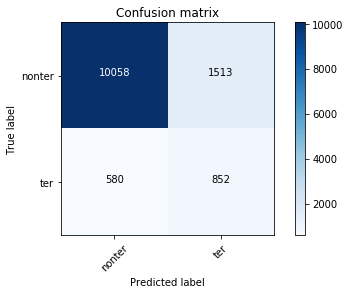

In [16]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

plot_confusion_matrix(cm, data.classes)

In [17]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y, probs[:,1], pos_label=1)
auc(fpr, tpr)

0.854909801473439

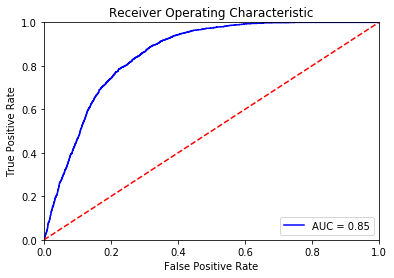

In [18]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc(fpr, tpr))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [29]:
data.classes

['nonter', 'ter']

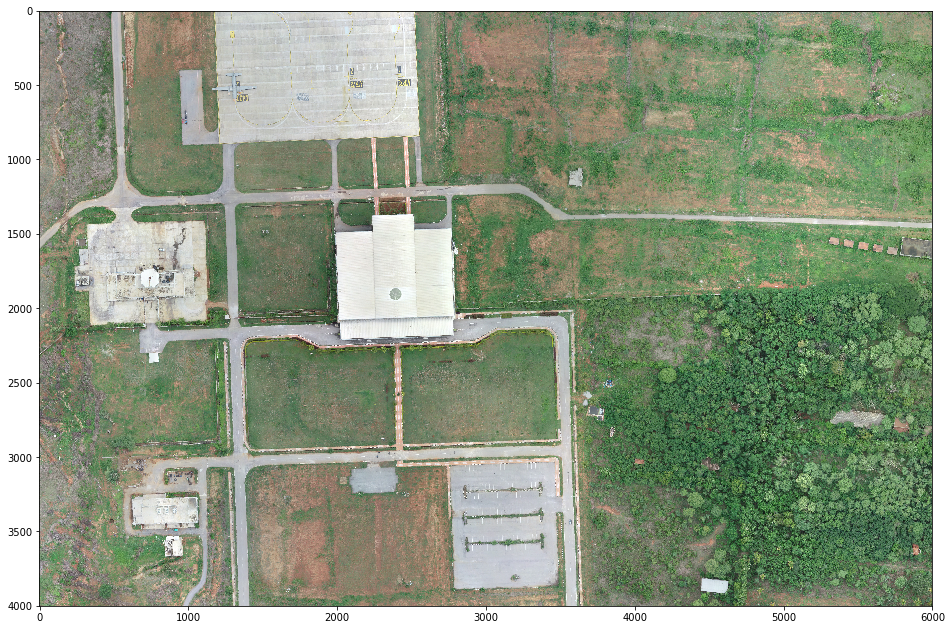

In [45]:
img = plt.imread('/home/rahul/code/test_mos.jpg')
plt.figure(figsize=(16,12))
plt.imshow(img);

In [20]:
img.shape

(400, 600, 3)

In [23]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), test_name='test1')

In [25]:
learn.set_data(data)

In [26]:
learn.load('224_all_ter_train_aug')
log_preds_test = learn.predict(is_test=True)
probs_test = np.mean(np.exp(log_preds_test),0)
#accuracy_np(probs, y)

In [30]:
probss = np.exp(log_preds_test[:0])

In [31]:
probss

array([], shape=(0, 2), dtype=float32)

In [28]:
np.exp(log_preds_test)

array([[0.74737, 0.25263],
       [0.98298, 0.01702],
       [0.97778, 0.02222],
       ...,
       [0.99947, 0.00053],
       [0.36835, 0.63165],
       [0.47879, 0.52121]], dtype=float32)

In [53]:
np.shape(img)

(400, 600, 3)

In [55]:
type(img[0,0,0])

numpy.uint8

In [51]:
res_img = np.zeros((4000,6000,3), dtype=np.uint8)
for i in range(2400):
    row, col = data.test_ds.fnames[i].split('_')[2:4]
    res_img[int(row)-8000+62:int(row)-8000+66,int(col)-17000+62:int(col)-17000+66, :] = np.ones((4,4,3), dtype=np.uint8)*np.uint8(np.exp(log_preds_test[i,1])*255)
    
"""

count = 0
for i in range(40):
    for j in range(60):
        res_img[10*i,10*j] = np.uint8(np.exp(log_preds_test[count,1])*255)
        count = count+1
        
        """

'\n\ncount = 0\nfor i in range(40):\n    for j in range(60):\n        res_img[10*i,10*j] = np.uint8(np.exp(log_preds_test[count,1])*255)\n        count = count+1\n        \n        '

In [37]:
file_name = data.test_ds.fnames[0]
lst = file_name.split('_')
lst[2:4]

['11700', '19500']

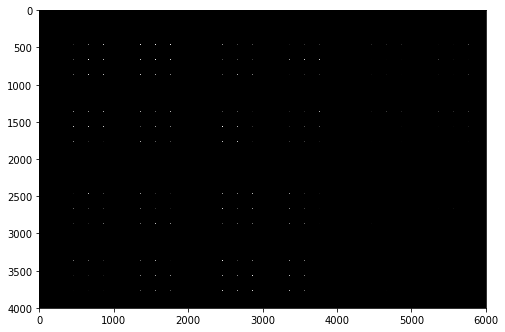

In [54]:
plt.figure(figsize=(8,6))
plt.imshow(res_img);


In [59]:
res_img[res_img<250]=0
cv2.imwrite('overlay3.jpg', res_img)

True

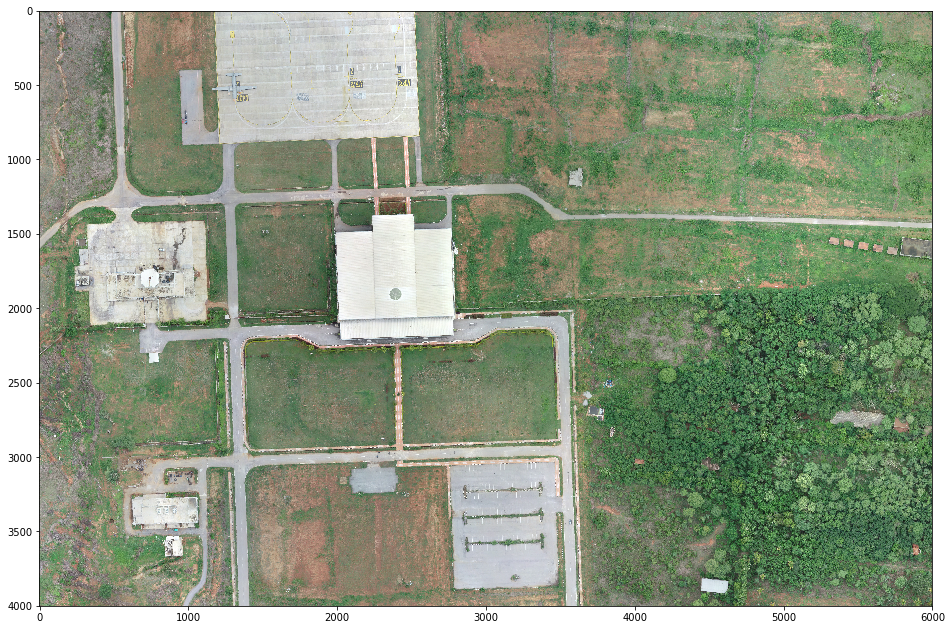

In [53]:
plt.figure(figsize=(16,12))
plt.imshow(img);

In [57]:
np.histogram(res_img[:], 100)

(array([71909712,     4272,     1584,     2400,     1584,     1920,     1152,     1920,     1008,     1776,
            1440,     1488,      576,     2160,     1200,     1920,     1776,      960,     1488,     1104,
            1536,      672,     1584,      720,     1008,      624,      912,     1152,     1104,      816,
             912,      720,     1392,     1008,      720,      960,      672,     1632,      960,     1248,
             672,     1344,      960,      864,      576,      816,      912,     1056,      336,     1104,
            1152,      480,      960,      624,      720,      528,     1056,      960,      432,      432,
             816,      432,      624,      480,      576,      576,      720,      960,      528,      864,
             528,      576,      384,      624,      336,      576,      576,      576,      384,      960,
             336,      672,      528,      912,      624,      336,      768,      528,      432,      672,
             864,      384, 

In [60]:
DataLoader

ModuleNotFoundError: No module named 'fastai.datasets'